In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from plato.instrument.noise import NoiseModel
from plato.planets.populations import PopulationModel
from plato.stars import filter_valid_targets
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults
from plato.utils import get_abspath

In [ ]:
set_plot_defaults()

figure_directory = f"/figures/B_stellar_variability/"
save = True

In [ ]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

In [29]:
fields["Noise (ppm)"] = (
    NoiseModel().calculate_noise(
        fields["Magnitude_V"],
        fields["n_cameras"],
        stellar_variability=0,
    )
    * 1e6
)

## NOISE DISTRIBUTION

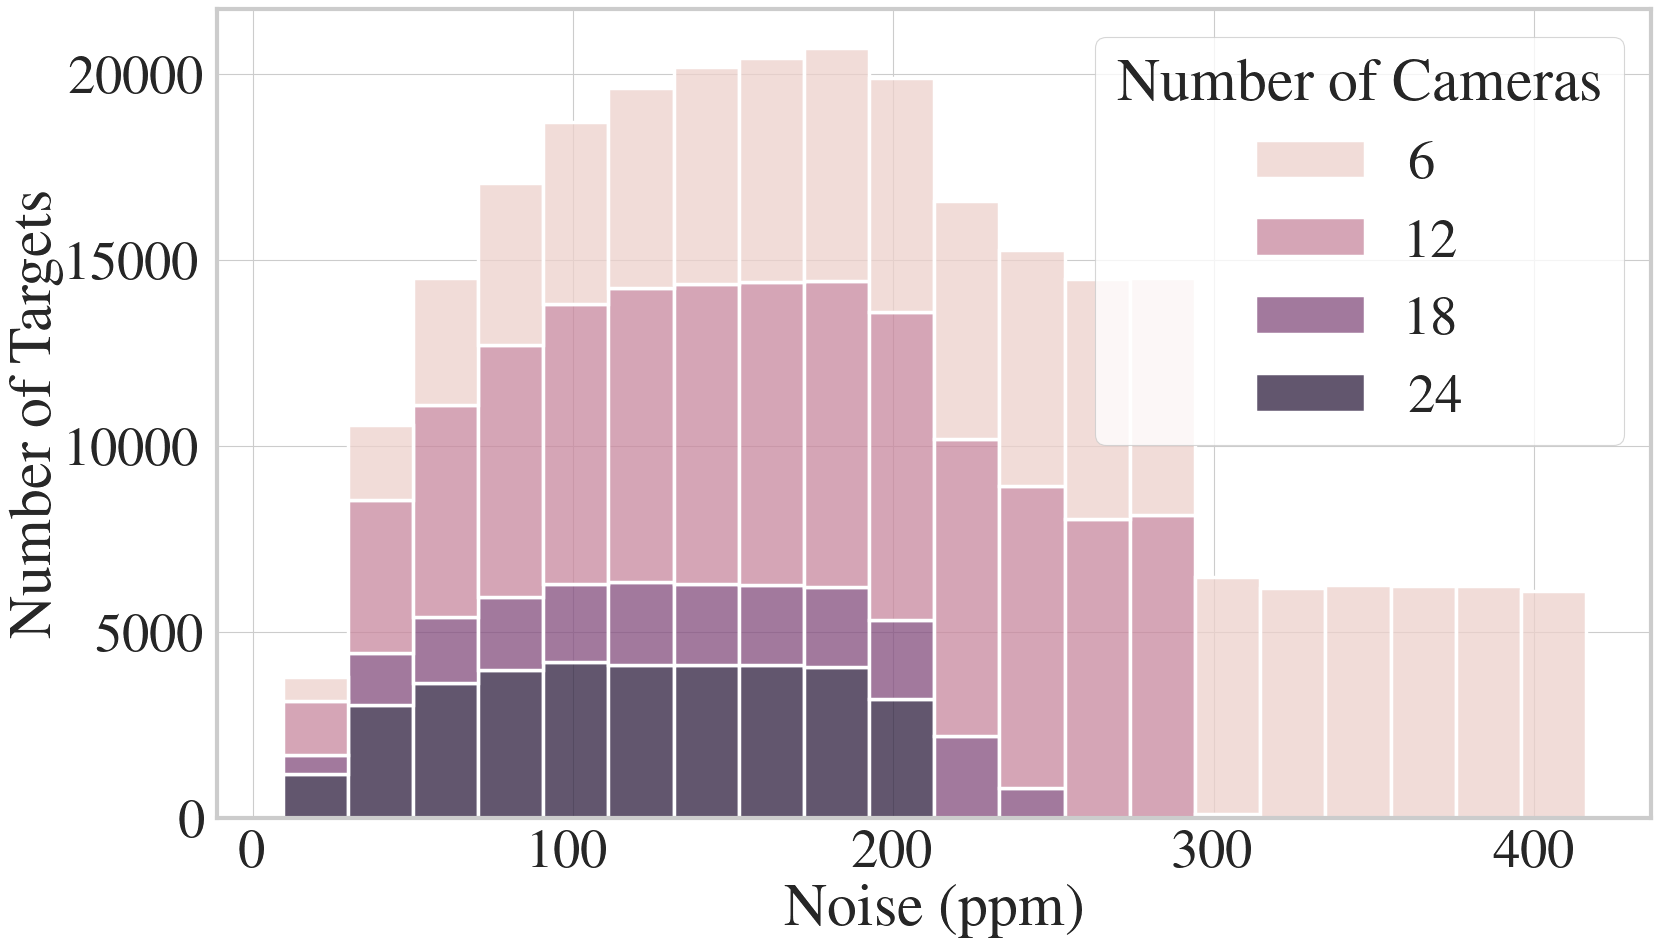

In [30]:
noise_plot = sns.histplot(
    data=fields,
    x="Noise (ppm)",
    hue="n_cameras",
    bins=20,
    linewidth=2.5,
    legend=True,
    edgecolor="white",
    multiple="stack",
)

noise_plot.get_legend().set_title("Number of Cameras")
noise_plot.set_ylabel("Number of Targets")

FigureProcessor(noise_plot).save(
    "noise_hist.pdf",
    figure_directory=figure_directory,
    save=save,
)

## CALCULATE PLANET YIELDS FOR DIFFERENT VALUES OF SIGMA_STAR

In [ ]:
population_model = PopulationModel(
    fields.sample(10000),
    num_embryos=100,
)

In [ ]:
stellar_variability = np.arange(0, 210, 10) * 1e-6

In [ ]:
table = {}

for sigma_star in tqdm(stellar_variability):
    population_model.update_stellar_variability(sigma_star)
    mock_observation = [population_model.create_mock_observation() for i in range(100)]
    table[sigma_star] = [len(mock) for mock in mock_observation]

table = pd.DataFrame.from_dict(table).T
table.index.name = "Stellar Variability (ppm)"
table.reset_index(inplace=True)
table["Stellar Variability (ppm)"] = table["Stellar Variability (ppm)"] * 1e6
table = table.melt(
    id_vars="Stellar Variability (ppm)",
    var_name="Mock Number",
    value_name="Number of Detected Planets",
)

# normalise
table["Planet Detections (Normalised)"] = (
    table["Number of Detected Planets"]
    / table[table["Stellar Variability (ppm)"] == 0][
        "Number of Detected Planets"
    ].mean()
)

In [ ]:
stellar_variability_plot = sns.lineplot(
    data=table,
    x="Stellar Variability (ppm)",
    y="Planet Detections (Normalised)",
    color=get_palette()[-2],
    linewidth=0,
    marker="o",
    markersize=13,
    err_style="bars",
    err_kws={"elinewidth": 3},
)

# fit a line and add to plot
fit = np.polyfit(
    table["Stellar Variability (ppm)"],
    table["Planet Detections (Normalised)"],
    1,
)
fit_fn = np.poly1d(fit)
stellar_variability_plot.plot(
    table["Stellar Variability (ppm)"],
    fit_fn(table["Stellar Variability (ppm)"]),
    color=get_palette()[2],
    linewidth=4,
    alpha=0.8,
)

stellar_variability_plot.axvline(
    10,
    color="lightgrey",
    linestyle="--",
    linewidth=3,
    zorder=-1,
)

FigureProcessor(stellar_variability_plot).save(
    "stellar_variability_plot.pdf",
    figure_directory=figure_directory,
    save=save,
)

In [ ]:
fit

In [ ]:
200 * 0.001